# Tianchi competition 

link: https://tianchi.aliyun.com/competition/entrance/531795/information

In [ ]:
# !pip install tensorflow-gpu
# !pip install pandas
# !pip install numpy
# !pip install opencv-python

#Install and import packages, upload original data file to Colab

In [1]:
import tensorflow as tf 
import pandas as pd 
import numpy as np 
from tensorflow import keras 
import os 
import cv2 
import json
from tqdm import tqdm 
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
np.__version__

'1.19.5'

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE 
IMAGE_SIZE = 224 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [4]:
data_links = pd.read_csv('/content/gdrive/My Drive/CV projects/streetViewHouseNumbers/data/mchar_data_list_0515.csv') 
data_links

,file,size,link
0,mchar_train.zip,345.91MB,http://tianchi-competition.oss-cn-hangzhou.ali...
1,mchar_train.json,3.16MB,http://tianchi-competition.oss-cn-hangzhou.ali...
2,mchar_val.zip,200.16MB,http://tianchi-competition.oss-cn-hangzhou.ali...
3,mchar_val.json,1.03MB,http://tianchi-competition.oss-cn-hangzhou.ali...
4,mchar_test_a.zip,370.6MB,http://tianchi-competition.oss-cn-hangzhou.ali...
5,mchar_sample_submit_A.csv,507.83KB,http://tianchi-competition.oss-cn-hangzhou.ali...


In [5]:
for i in range(0, 5): 
  files_path = tf.keras.utils.get_file(data_links["file"].iloc[i], data_links["link"].iloc[i], extract=True) 
print("files_path: ", files_path) 

388612096/388603696 [==============================] - 111s 0us/step
files_path:  /root/.keras/datasets/mchar_test_a.zip


In [6]:
files_path = '/root/.keras/datasets/'
data_path = os.path.dirname(files_path) 
os.listdir(data_path)

['mchar_train',
 'mchar_val',
 'mchar_val.json',
 'mchar_test_a',
 'mchar_test_a.zip',
 '__MACOSX',
 'mchar_train.json',
 'mchar_val.zip',
 'mchar_train.zip']

In [7]:
train_pics_path = data_path + "/mchar_train" 
train_labels_path = data_path + "/mchar_train.json" 
val_pics_path = data_path + "/mchar_val" 
val_labels_path = data_path + "/mchar_val.json" 
print("train pics: ", len(os.listdir(train_pics_path)), "\nval pics: ", len(os.listdir(val_pics_path)))

train pics:  30000 
val pics:  10000


In [8]:
def read_json(file_path): 
  json_file = open(file_path, 'r')
  data = json.load(json_file)
  json_file.close()
  return data 

train_json = read_json(train_labels_path)
val_json = read_json(val_labels_path)

#Study data, preprocess and create training and validation dataset

In [ ]:
#check classes 
num_label = {} 
for img in os.listdir(train_pics_path): 
  labels = train_json[img]["label"]
  if len(labels) in num_label: 
    num_label[len(labels)] += 1
  else: 
    num_label[len(labels)] = 1 
num_label 

{1: 4636, 2: 16262, 3: 7813, 4: 1280, 5: 8, 6: 1}

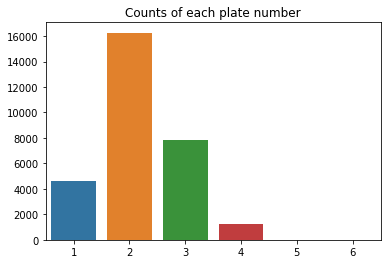

In [ ]:
number = [key for key in num_label] 
count = [num_label[key] for key in num_label] 
sns.barplot(x = number, y = count).set_title("Counts of each plate number")

plt.show()

In [9]:
def process_image(img_path): 
  image = tf.io.read_file(img_path)
  image = tf.image.decode_png(image, channels = 3)
  image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
  image /= 255.0
  return image

def preprocess_x(img_path): 
  sorted_img_path = sorted(os.listdir(img_path)) 
  sorted_img_path = [img_path + '/' + img for img in sorted_img_path] 

  image_path = tf.data.Dataset.from_tensor_slices(sorted_img_path) 
  image_dataset = image_path.map(process_image, num_parallel_calls = AUTOTUNE) 
  return image_dataset

In [10]:
def preprocess_y(label_path): 
  label_file = read_json(label_path) 
  labels = [] 
  label_len = 4 

  for image in label_file: 
    label = label_file[image]['label'] 
    if len(label) < label_len: 
      label = label + [10] * (label_len - len(label)) 
      label = [float(x) for x in label] 
    label = label[:label_len]
    labels.append(list(label))

  label_dataset = tf.data.Dataset.from_tensor_slices(labels)
  return label_dataset

In [11]:
train_x = preprocess_x(train_pics_path) 
train_y = preprocess_y(train_labels_path) 
TRAIN_DATA = tf.data.Dataset.zip((train_x, train_y)) 

In [12]:
val_x = preprocess_x(val_pics_path) 
val_y = preprocess_y(val_labels_path) 
VALIDATION_DATA = tf.data.Dataset.zip((val_x, val_y)) 

In [13]:
VALIDATION_DATA

<ZipDataset shapes: ((224, 224, 3), (4,)), types: (tf.float32, tf.float32)>

#Build model and evaluate

In [ ]:
# TRAIN_DATA = tf.data.experimental.load('/content/drive/My Drive/CV projects/streetViewHouseNumbers/dataset_train') 
# VALIDATION_DATASET = tf.data.experimental.load('/content/drive/My Drive/CV projects/streetViewHouseNumbers/dataset_val') 

In [14]:
batch_size = 32
train_dataset = TRAIN_DATA.shuffle(30000).repeat(-1) 
train_dataset = train_dataset.batch(batch_size) 
train_dataset = train_dataset.prefetch(AUTOTUNE) 

val_dataset = VALIDATION_DATA.batch(batch_size) 

In [15]:
input_size = (IMAGE_SIZE, IMAGE_SIZE, 3) 
pool_size = (2, 2) 
kernel_size=(3, 3)
dropout = 0.5 

def build_model(): 
    input_layer = Input(shape = input_size)

    x = Conv2D(16, kernel_size, padding = "same", activation='relu')(input_layer)
    x = Conv2D(16, kernel_size, padding = "same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size)(x)
    
    x = Conv2D(32, kernel_size, padding = "same", activation='relu')(x)
    x = Conv2D(32, kernel_size, padding = "same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size)(x)
    
    x = Conv2D(64, kernel_size, padding = "same", activation='relu')(x)
    x = Conv2D(64, kernel_size, padding = "same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size)(x)

    x = Conv2D(32, kernel_size, padding = "same", activation='relu')(x)
    x = Conv2D(32, kernel_size, padding = "same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size)(x)

    x = Flatten()(x)

    number1 = Dense(64, activation='relu')(x) 
    number1 = Dense(11, activation='softmax', name='number1')(number1) 
    number2 = Dense(64, activation='relu')(x) 
    number2 = Dense(11, activation='softmax', name='number2')(number2) 
    number3 = Dense(64, activation='relu')(x) 
    number3 = Dense(11, activation='softmax', name='number3')(number3) 
    number4 = Dense(64, activation='relu')(x) 
    number4 = Dense(11, activation='softmax', name='number4')(number4) 

    model = Model(inputs = input_layer, outputs = [number1, number2, number3, number4])
    return model 

In [16]:
baseline_model = build_model() 
# baseline_model.summary() 

In [17]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

def loss(model, inputs, l_label):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

    c0, c1, c2, c3 = model(inputs)
    loss = loss_object(l_label[:,0], c0) + loss_object(l_label[:,1], c1) + loss_object(l_label[:,2], c2) + loss_object(l_label[:,3], c3)
    return loss

def reshape_tensor(tensor):
    num_tensor = np.array(tensor)
    num_tensor = num_tensor.T
    return num_tensor


In [18]:
# train model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) 
epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
num_epochs = 10
train_loss_results = []
train_accuracy_results = []

print("Start training------------------------------------------------------------------------------------------------------------------")
for epoch in range(num_epochs):
    step = 0
    for x, y in train_dataset:
        loss_value, grads = grad(baseline_model, x, y)
        optimizer.apply_gradients(zip(grads, baseline_model.trainable_variables))
        epoch_loss_avg(loss_value)
        epoch_accuracy(reshape_tensor(y), baseline_model(x))
        step += 1
        if step % 100 == 0:
            print("Step: {}, Loss: {:.4f}, Accuracy: {:.3%}".format(step, epoch_loss_avg(loss_value).numpy(), epoch_accuracy(reshape_tensor(y), baseline_model(x)).numpy()))
        if step * batch_size >= 30000: 
            break 
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch+1, epoch_loss_avg.result(), epoch_accuracy.result()))

print("End----------------------------------------------------------------------------------------------------------------------------")

Start training------------------------------------------------------------------------------------------------------------------
Step: 100, Loss: 6.1896, Accuracy: 51.849%
Step: 200, Loss: 6.1137, Accuracy: 51.872%
Step: 300, Loss: 6.0755, Accuracy: 51.949%
Step: 400, Loss: 6.0548, Accuracy: 52.027%
Step: 500, Loss: 6.0369, Accuracy: 51.997%
Step: 600, Loss: 6.0165, Accuracy: 52.073%
Step: 700, Loss: 5.9946, Accuracy: 52.125%
Step: 800, Loss: 5.9752, Accuracy: 52.202%
Step: 900, Loss: 5.9391, Accuracy: 52.380%
Epoch 001: Loss: 5.925, Accuracy: 52.485%
Step: 100, Loss: 5.8694, Accuracy: 52.980%
Step: 200, Loss: 5.7870, Accuracy: 53.724%
Step: 300, Loss: 5.6917, Accuracy: 54.584%
Step: 400, Loss: 5.6047, Accuracy: 55.374%
Step: 500, Loss: 5.5014, Accuracy: 56.271%
Step: 600, Loss: 5.3979, Accuracy: 57.214%
Step: 700, Loss: 5.3031, Accuracy: 58.054%
Step: 800, Loss: 5.2120, Accuracy: 58.883%
Step: 900, Loss: 5.1279, Accuracy: 59.631%
Epoch 002: Loss: 5.099, Accuracy: 59.883%
Step: 100, Lo

In [19]:
val_x = val_x.batch(batch_size) 
val_x = val_x.prefetch(AUTOTUNE) 
predictions = baseline_model.predict(val_x) 

In [20]:
def make_prediction(predictions): 
  Val_prediction = [] 
  for number_id in range(len(predictions)): 
    for picture_id in range(len(predictions[number_id])): 
      if number_id == 0: 
        Val_prediction.append([np.argmax(predictions[number_id][picture_id])]) 
      else: 
        Val_prediction[picture_id].append(np.argmax(predictions[number_id][picture_id]))
  return Val_prediction 

def clean(Val_prediction): 
  Val_prediction_clean = []
  for i in range(len(Val_prediction)): 
    numbers = Val_prediction[i] 
    new = [] 
    for number in numbers: 
      if int(number) != 10: 
        new.append(int(number)) 
    if len(new) == 0: 
      new.append(1)
    Val_prediction_clean.append(list(new)) 
  return Val_prediction_clean

In [21]:
Val_prediction = make_prediction(predictions)
Val_prediction_clean = clean(Val_prediction) 

In [22]:
def compare(y, pred): 
  if len(y) != len(pred): 
    return False 
  for i in range(len(y)): 
    if y[i] != pred[i]: 
      return False 
  return True 

def evaluate(Y, Pred): 
  match = 0
  for i in range(len(Y)): 
    y = Y[i] 
    pred = Pred[i] 
    if compare(y, pred) == True: 
      match += 1 
  
  return match/len(Y)

In [23]:
label_file = read_json(val_labels_path) 
val_labels_true = [] 
for img in label_file: 
  label = label_file[img]['label'] 
  val_labels_true.append(label)

In [24]:
val_acc = evaluate(val_labels_true, Val_prediction_clean)
val_acc

0.2434

## Prediction for testing set

In [25]:
files_path = '/root/.keras/datasets/'
data_path = os.path.dirname(files_path) 
os.listdir(data_path)

['mchar_train',
 'mchar_val',
 'mchar_val.json',
 'mchar_test_a',
 'mchar_test_a.zip',
 '__MACOSX',
 'mchar_train.json',
 'mchar_val.zip',
 'mchar_train.zip']

In [26]:
test_pics_path = data_path + "/mchar_test_a" 
test_x = preprocess_x(test_pics_path) 
test_x = test_x.batch(batch_size) 
test_x = test_x.prefetch(AUTOTUNE) 
test_predictions = baseline_model.predict(test_x) 

In [27]:
test_prediction = make_prediction(test_predictions)
test_prediction_clean = clean(test_prediction) 

In [28]:
sorted_img_path = sorted(os.listdir(test_pics_path)) 
test_prd = []
for i in range(len(sorted_img_path)): 
  numbers = [str(num) for num in test_prediction_clean[i]] 
  plate = ''.join(numbers)
  test_prd.append((sorted_img_path[i], plate))

In [29]:
test_upload = pd.DataFrame(test_prd, columns=['file_name', 'file_code'])
test_upload.head()

,file_name,file_code
0,000000.png,3
1,000001.png,108
2,000002.png,138
3,000003.png,95
4,000004.png,3


In [31]:
test_upload.to_csv(path_or_buf = '/content/gdrive/My Drive/CV projects/streetViewHouseNumbers/outputs/baseline2.csv', index = False)